In [1]:
library(Seurat)
library(SeuratWrappers)
library(ggplot2)
library(cowplot)
library(monocle3)
library(dplyr)
library(tidyr)
library(future)
library(stringr)
library(scRepertoire)
library(Trex)
library(patchwork)
library(ggrepel)
library(slingshot)
library(scExtras)
library(rstatix)
library(pROC)
library(UCell)
library(ggraph)
library(circlize)
library(scales)
library(scDblFinder)
library(BiocParallel)
library(org.Mm.eg.db)
library(clusterProfiler)
library(enrichplot)
library(tibble)
library(ggpubr)
library(tidydr)
library(corrplot)
library(harmony)
library(reshape2)
library(ComplexHeatmap)
library(RColorBrewer)
library(randomcoloR)
library(escape)
library(ggridges)
library(scatterpie)
options(jupyter.plot_scale=1, repr.matrix.max.cols=200)
`%nin%` = Negate(`%in%`)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVi

In [2]:
update_geom_defaults("point", aes(stroke = 0.1))
source('utils_tcr.R')

In [3]:
seu <- readRDS('data/b16_5batch.rds')

In [4]:
tc <- readRDS('data/b16_tc_5batch.rds')

# Clustering and annotation

In [5]:
tc <- seu %>% subset(type == 'T')
tc

An object of class Seurat 
32285 features across 18257 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [6]:
tc <- tc %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData() %>% 
    RunPCA(verbose = FALSE, npcs = 50) %>% RunHarmony('batch')

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



In [7]:
tc <- tc %>% 
    FindNeighbors(dims = 1:30, verbose=FALSE, k.param=15, reduction='harmony') %>% 
    FindClusters(resolution = 0.6, verbose=FALSE) %>% 
    RunUMAP(dims = 1:30, verbose=FALSE, min.dist=0.3, reduction='harmony') 

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


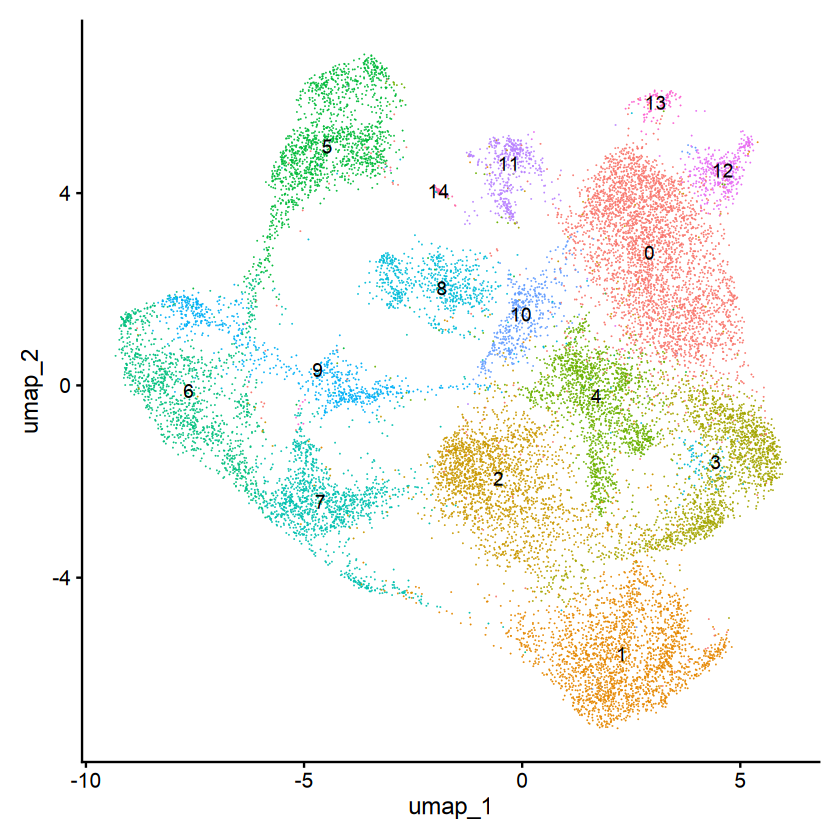

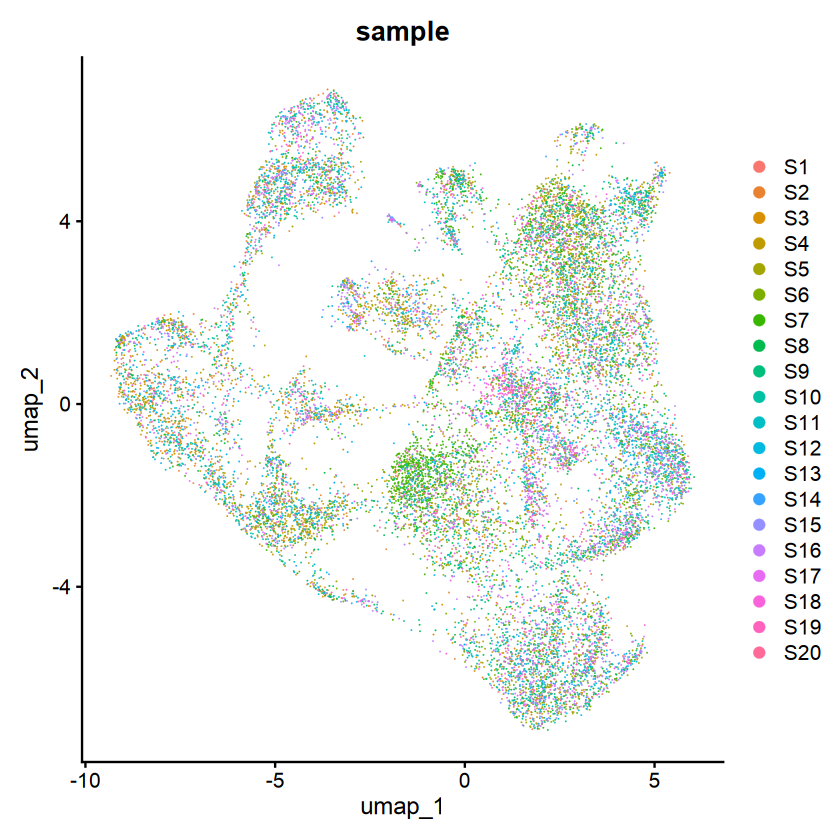

In [8]:
DimPlot(tc, label=TRUE) + NoLegend()
DimPlot(tc, group.by='sample', label=F) 

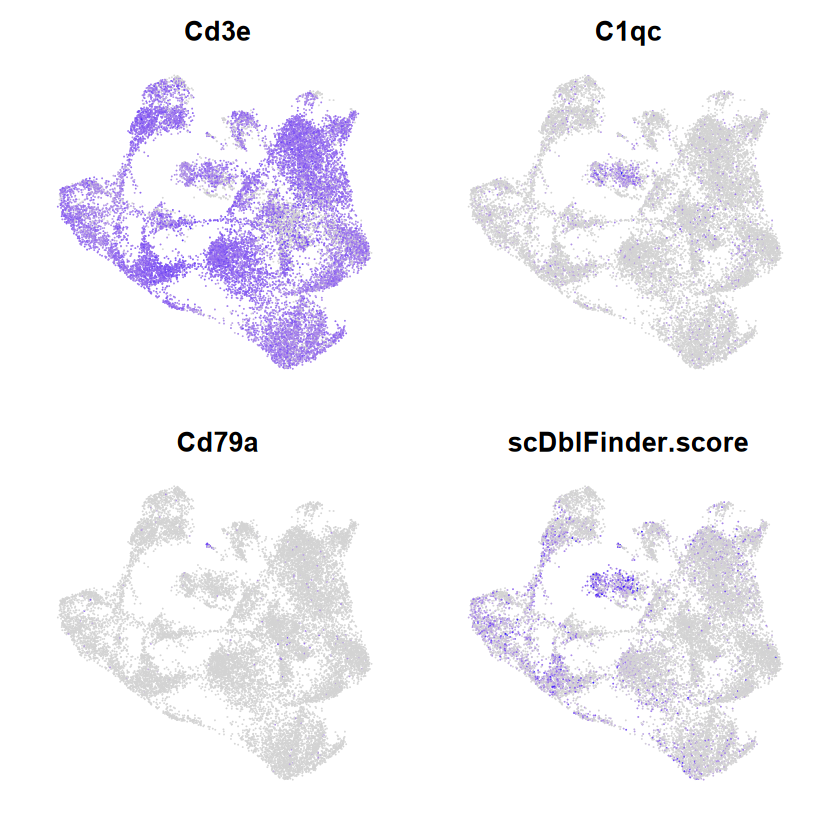

In [9]:
FeaturePlot(tc, c('Cd3e','C1qc','Cd79a','scDblFinder.score')) & NoLegend() & NoAxes()

In [10]:
# cluster 9 are myeloid-T doublets and cluster 14 are B-T doublets
tc <- subset(tc, seurat_clusters %nin% c(8,14))
tc

An object of class Seurat 
32285 features across 17447 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [11]:
tc <- tc %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData(verbose = FALSE) %>% 
    RunPCA(npcs = 50, verbose = FALSE) %>% RunHarmony('batch')

Warning message:
“Different features in new layer data than already exists for scale.data”
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



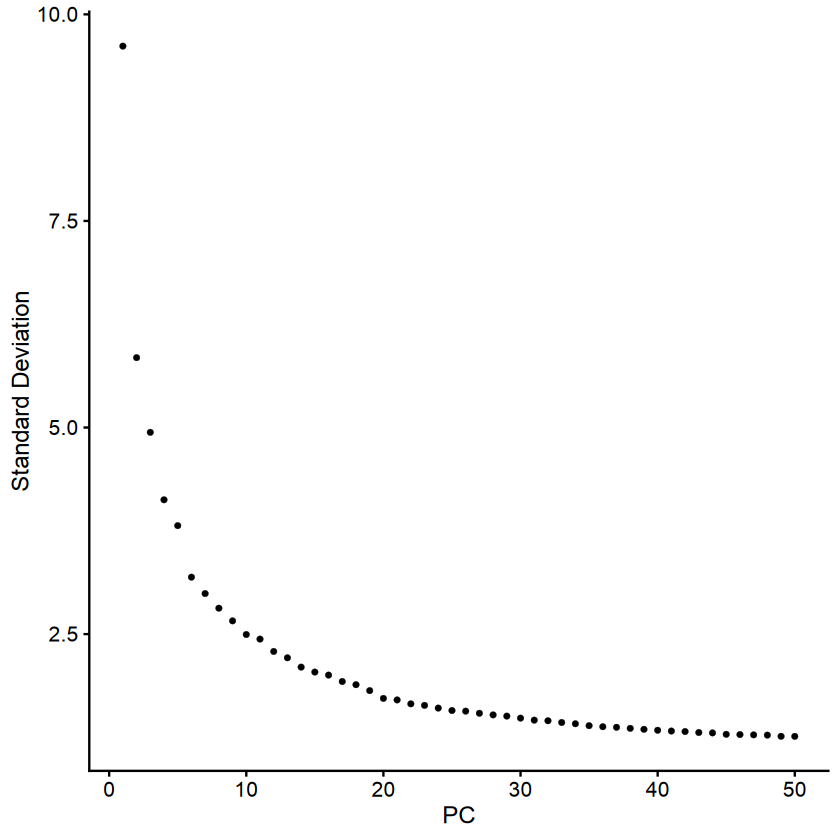

In [12]:
ElbowPlot(tc, 50)

In [13]:
tc <- tc %>%  
    FindNeighbors(dims = 1:30, verbose=FALSE, k.param=15) %>% #, reduction='harmony'
    FindClusters(resolution = 0.8, verbose=FALSE) %>% 
    RunUMAP(dims = 1:30, verbose=FALSE, min.dist=0.4, reduction='harmony') 

In [14]:
tc <- readRDS('data/b16_tc_5batch.rds')

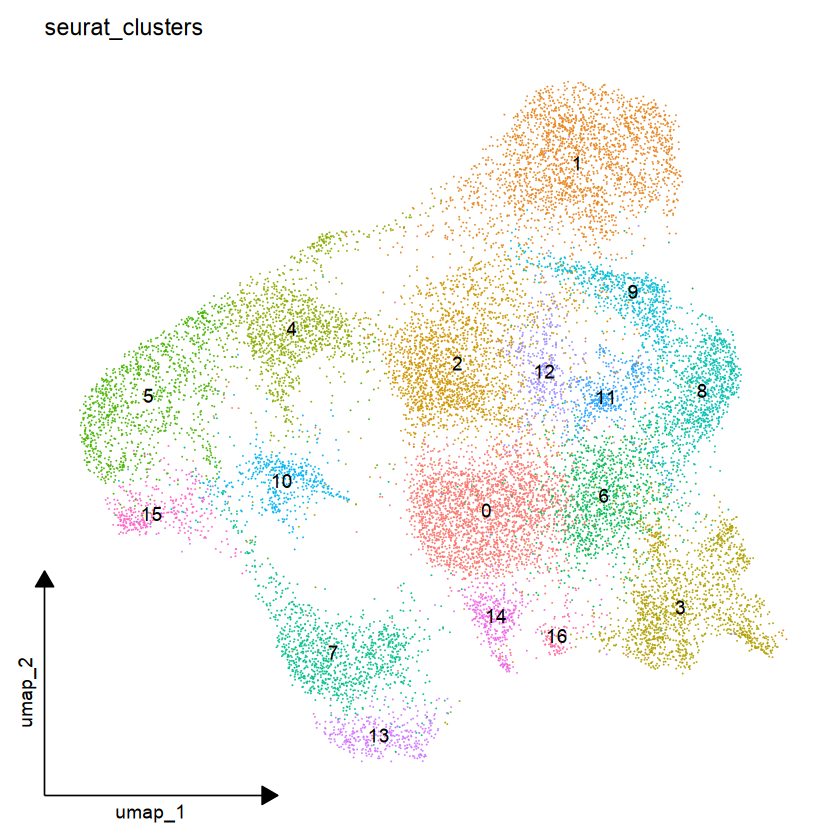

In [15]:
DimPlot(tc, label=TRUE, group.by='seurat_clusters') + theme_dr() + theme(panel.grid=element_blank(), legend.position='none')

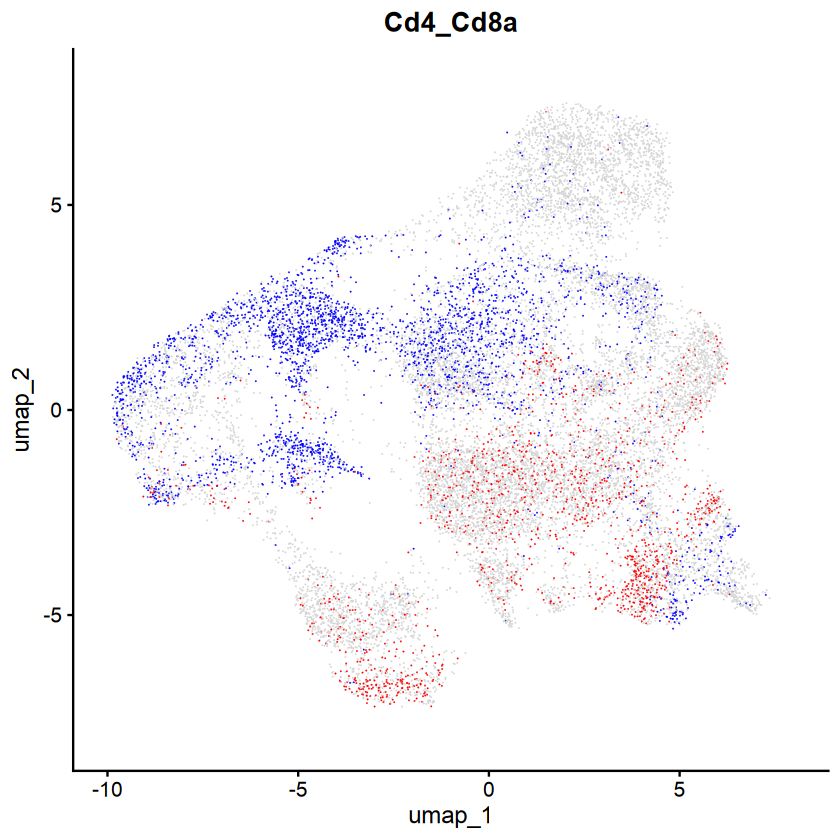

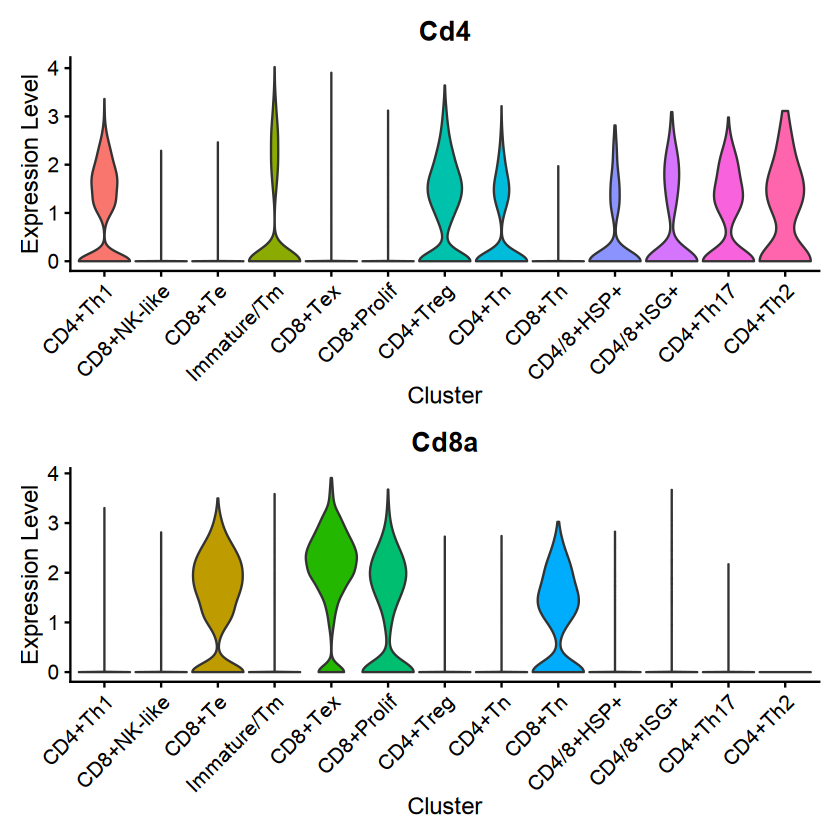

In [16]:
FeaturePlot(tc, features = c("Cd4", "Cd8a"), blend = TRUE, cols = c("lightgrey", "#ff0000", "#0000ff"))[[3]]
VlnPlot(tc, features = c("Cd4", "Cd8a"), pt.size=0, ncol=1) & labs(x='Cluster')

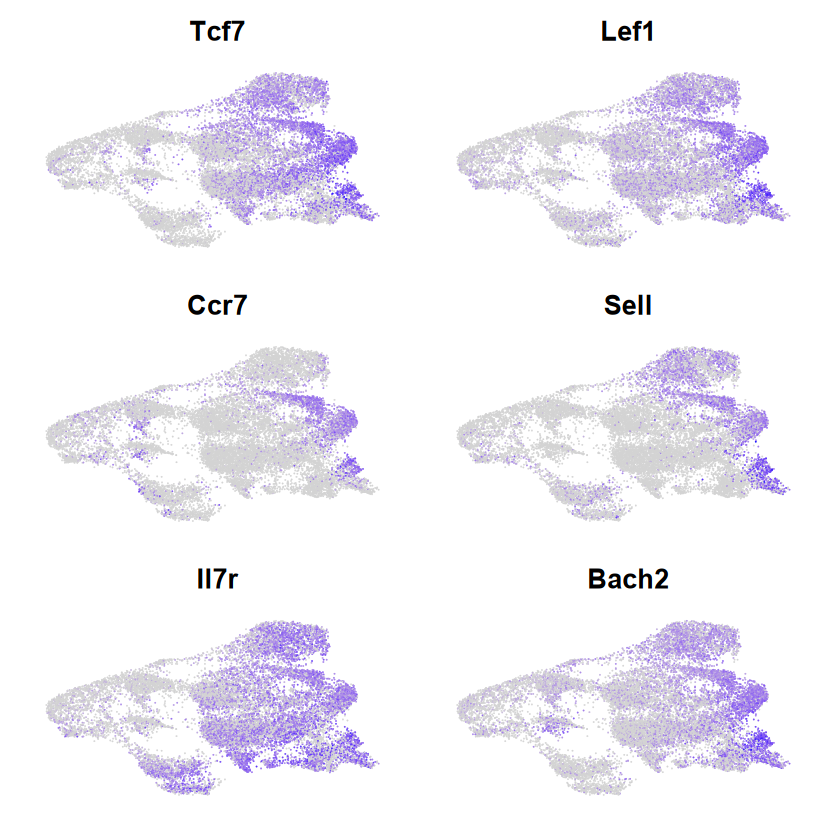

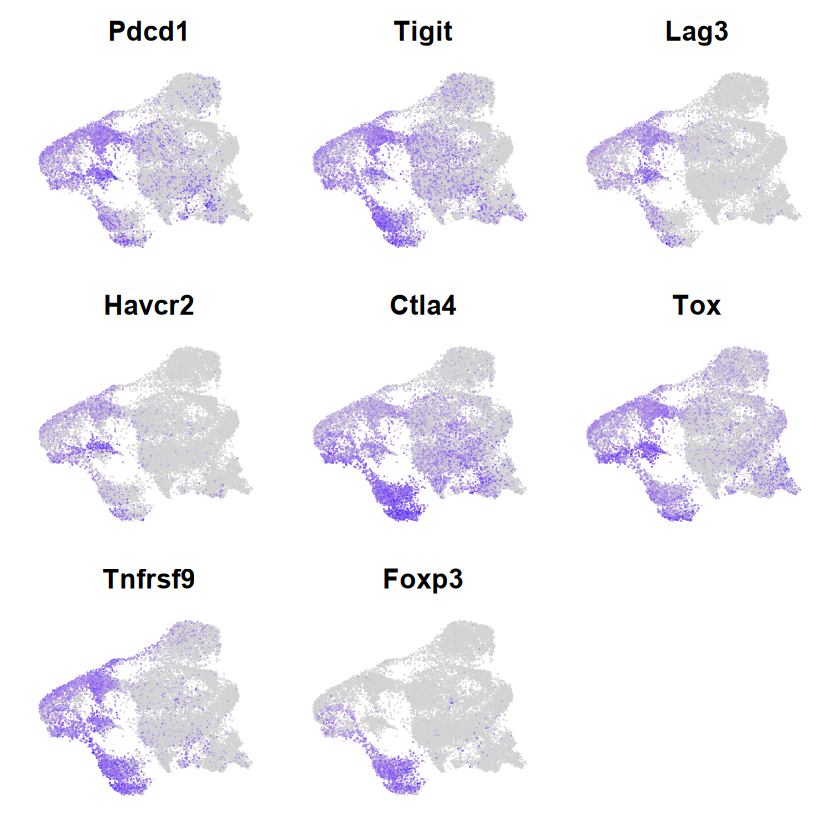

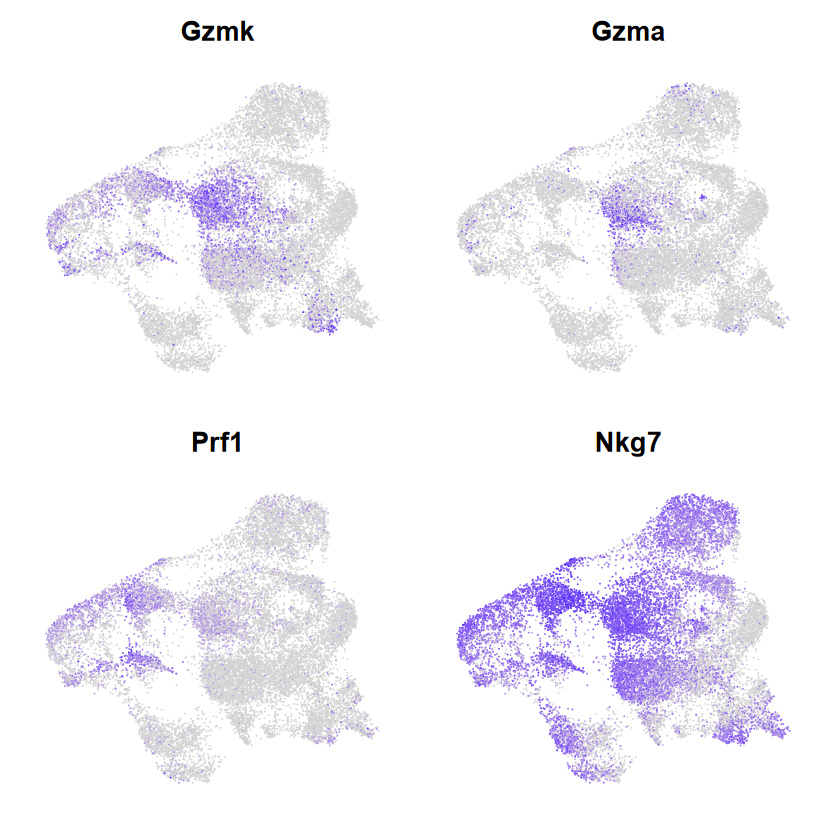

In [17]:
FeaturePlot(tc, c('Tcf7','Lef1','Ccr7','Sell','Il7r','Bach2')) & NoLegend() & NoAxes()
FeaturePlot(tc, c('Pdcd1','Tigit','Lag3','Havcr2','Ctla4','Tox','Tnfrsf9','Foxp3')) & NoLegend() & NoAxes()
FeaturePlot(tc, c('Gzmk','Gzma','Prf1','Nkg7')) & NoLegend() & NoAxes()

In [18]:
tc$annotation <- recode(tc$seurat_clusters, '0'='CD4+Th1', '1'='CD8+NK-like', '2'='CD8+Te','3'='Immature/Tm',
                        '4'='CD8+Tex','5'='CD8+Prolif', '6'='CD4+Th1','7'='CD4+Treg','8'='CD4+Tn','9'='CD8+Tn','10'='CD8+Tex',
                        '11'='CD4/8+HSP+','12'='CD4/8+ISG+', '13'='CD4+Treg','14'='CD4+Th17','15'='CD8+Prolif','16'='CD4+Th2')
tc$cluster_annotation <- recode(tc$seurat_clusters, '0'='0:CD4+Th1', '1'='1:CD8+NK-like', '2'='2:CD8+Te','3'='3:Immature/Tm',
                        '4'='4:CD8+Tex','5'='5:CD8+Prolif', '6'='6:CD4+Th1','7'='7:CD4+Treg','8'='8:CD4+Tn','9'='9:CD8+Tn','10'='10:CD8+Tex',
                        '11'='11:CD4/8+HSP+','12'='12:CD4/8+ISG+', '13'='13:CD4+Treg','14'='14:CD4+Th17','15'='15:CD8+Prolif','16'='16:CD4+Th2')
tc$CDsubset <- recode(tc$seurat_clusters, '0'='CD4','1'='CD8','2'='CD8','3'='else','4'='CD8','5'='CD8','6'='CD4','7'='CD4',
                       '8'='CD4','9'='CD8','10'='CD8','11'='else','12'='else','13'='CD4','14'='CD4','15'='CD8','16'='CD4')

In [19]:
table(tc$CDsubset)


 CD4  CD8 else 
6609 8403 2435 

In [20]:
table(tc@meta.data$annotation)


    CD4+Th1 CD8+NK-like      CD8+Te Immature/Tm     CD8+Tex  CD8+Prolif 
       3628        2323        2153        1582        1695        1526 
   CD4+Treg      CD4+Tn      CD8+Tn  CD4/8+HSP+  CD4/8+ISG+    CD4+Th17 
       1511         999         706         446         407         371 
    CD4+Th2 
        100 

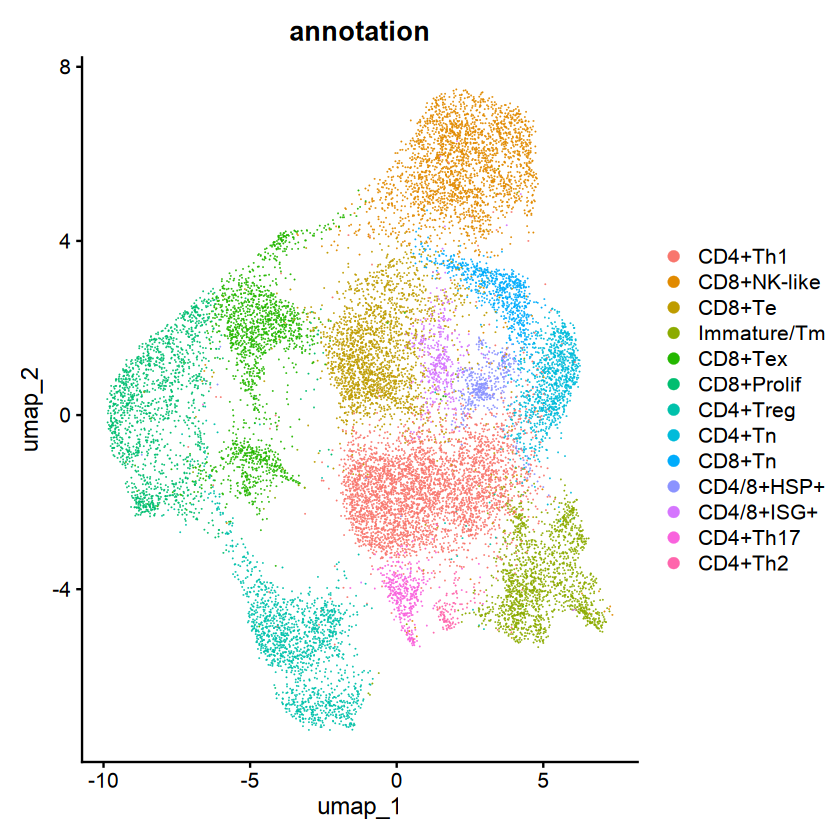

In [21]:
DimPlot(tc, group.by='annotation')

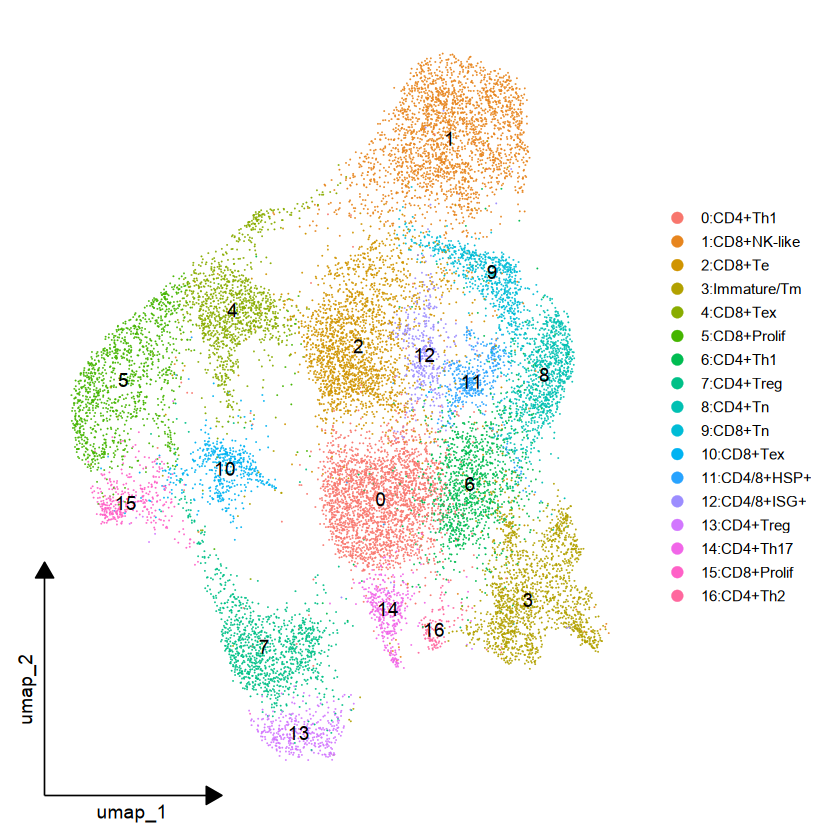

In [22]:
Idents(tc) <- 'seurat_clusters'
DimPlot(tc, label=TRUE) + theme_dr() + theme(panel.grid=element_blank(), legend.key.height=unit(0.5,'cm')) +
    scale_color_discrete(labels=c('0:CD4+Th1', '1:CD8+NK-like', '2:CD8+Te','3:Immature/Tm',
                        '4:CD8+Tex','5:CD8+Prolif', '6:CD4+Th1','7:CD4+Treg','8:CD4+Tn','9:CD8+Tn','10:CD8+Tex',
                        '11:CD4/8+HSP+','12:CD4/8+ISG+', '13:CD4+Treg','14:CD4+Th17','15:CD8+Prolif','16:CD4+Th2'))
ggsave('plot/b16_umap_t_5batch.pdf', width=5, height=4, device=pdf)

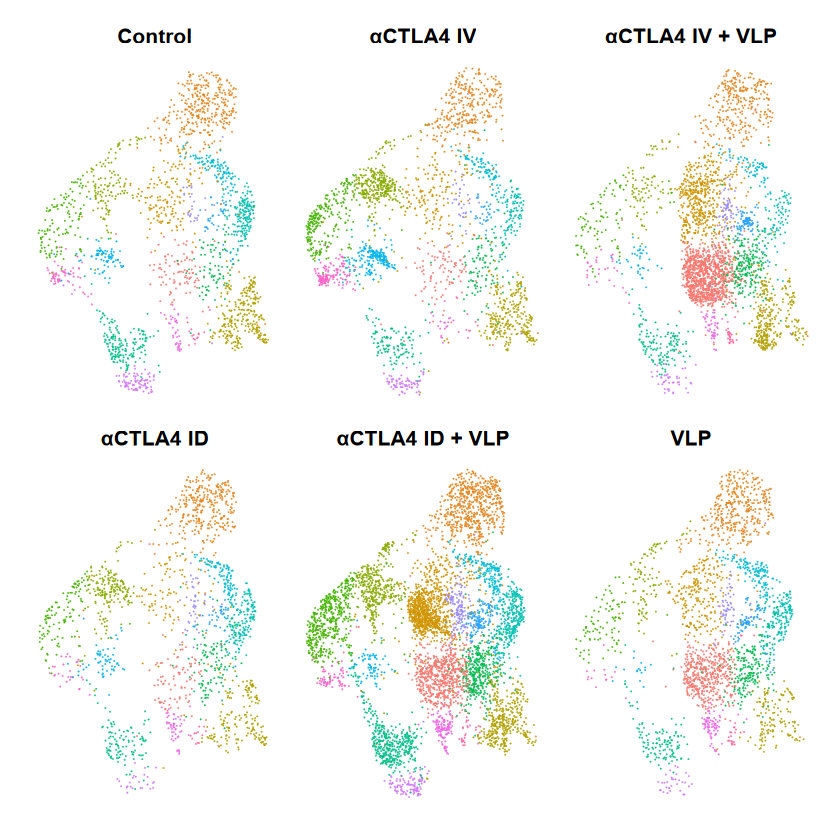

In [23]:
umap_tc_treat <- DimPlot(tc, label=F, split.by='treatment', ncol=3) + NoLegend() + NoAxes()
umap_tc_treat

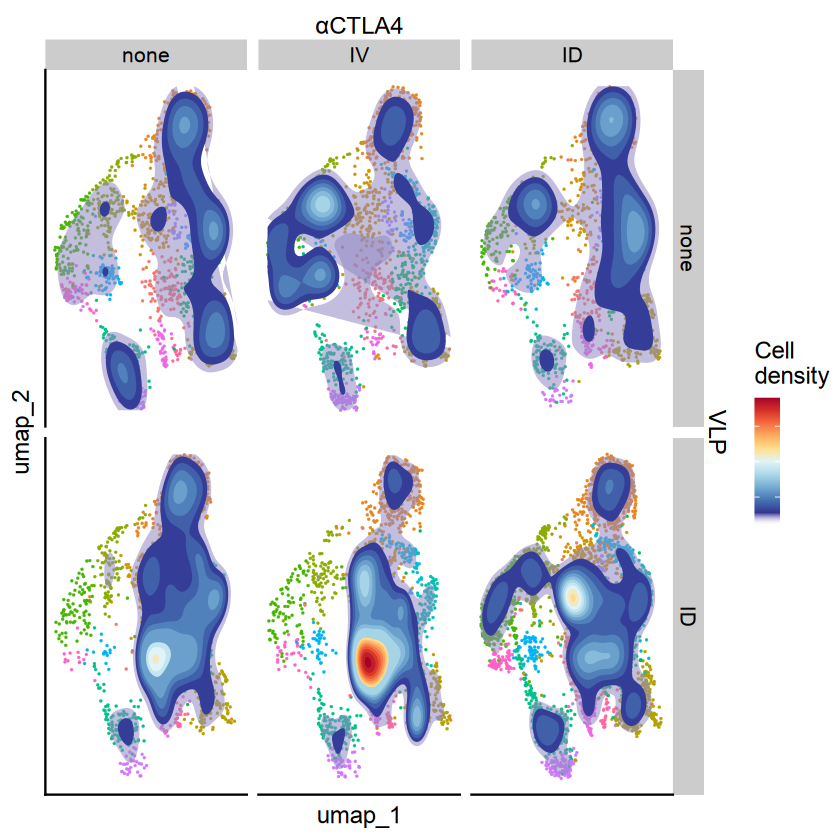

In [24]:
df_treatment_umap <- data.frame(tc@reductions$umap@cell.embeddings, tc@meta.data) %>%
    group_by(treatment) %>% 
    mutate(VLP=factor(VLP, levels=c('none','ID')), aCTLA4=factor(aCTLA4, levels=c('none','IV','ID')))
ggplot(df_treatment_umap, aes(x = umap_1, y = umap_2)) + 
  geom_point(aes(color=seurat_clusters), size=0.5) + 
  stat_density_2d(aes(fill=after_stat(level)), geom = "polygon", bins = 20) + 
  facet_grid(VLP~aCTLA4) + 
  scale_fill_gradientn(colors = c(NA,rev(brewer.pal(10, "RdYlBu")))) + 
  labs(fill='Cell\ndensity') + guides(color='none') +
  theme_cowplot() + theme(axis.text=element_blank(), axis.ticks=element_blank(), legend.text=element_blank())  +
  scale_y_continuous(sec.axis = sec_axis(~ . , name = "VLP", breaks = NULL, labels = NULL)) +
  scale_x_continuous(sec.axis = sec_axis(~ . , name = "αCTLA4", breaks = NULL, labels = NULL))
ggsave('plot/b16_umap_density_tc_5batch_by_treatment.pdf', height=5.5, width=8, device=cairo_pdf)

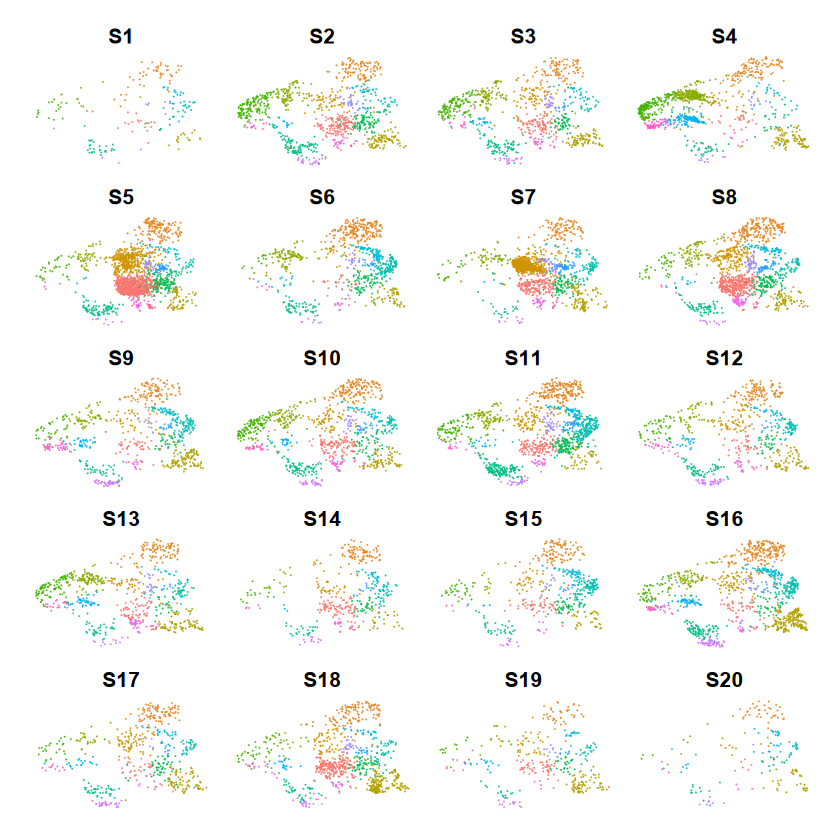

In [25]:
DimPlot(tc, label=F, split.by='sample', ncol=4)  + NoLegend() + NoAxes()

In [26]:
Idents(tc) <- 'seurat_clusters'
markers_tc_cluster <- FindAllMarkers(tc, assay='RNA', only.pos=T, logfc.threshold=0.5, min.pct=0.1)
Idents(tc) <- 'annotation'
markers_tc <- FindAllMarkers(tc, assay='RNA', only.pos=T, logfc.threshold=0.5, min.pct=0.1)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster CD4+Th1

Calculating cluster CD8+NK-like

Calculating cluster CD8+Te

Calculating cluster Immature/Tm

Calculating cluster CD8+Tex

Calculating cluster CD8+Prolif

Calculating cluster CD4+Treg

Calculating cluster CD4+Tn

Calculating cluster CD8+Tn

Calculating cluster CD4/8+HSP+

Calculating cluster CD4/8+ISG+

Calculating cluster CD4+Th17

Calculating cluster CD4+Th2



In [27]:
tc_key_genes <- c('Cd3e','Cd4','Cd8a',
                  'Sell','Ccr7','Il7r','Cd28','Fas','Cd27','Itgae','Itgal','Itgam','Itgax',
                  'Pdcd1','Tigit','Havcr2','Lag3','Ctla4','Vtcn1','Cd244a','Tnfrsf14','Btla','Cd160',
                  'Cd38','Entpd1','Nt5e','Cd69','Il2ra','Icos','Tnfrsf4','Tnfrsf9','Cd40lg',
                  'Gzma','Gzmb','Gzmc','Gzmk','Gzmm','Prf1','Nkg7','Ifng','Fasl','Tnf','Il17a','Il2',
                  'Lef1','Tcf7','Eomes','Tbx21','Prdm1','Tox','Gata3','Id2','Id3','Nr4a1','Zfp683','Foxp3','Mki67','Top2a',
                  'Tcrg-V6','Trdv4','Klra7','Klrb1c'
                 )
tc <- ScaleData(tc, features=tc_key_genes)
key_genes_mat <- as.matrix(AverageExpression(tc, features=tc_key_genes, group.by='seurat_clusters', slot='data')$RNA[tc_key_genes,]) 

Centering and scaling data matrix

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `seurat_clusters` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.


pdf 
  2

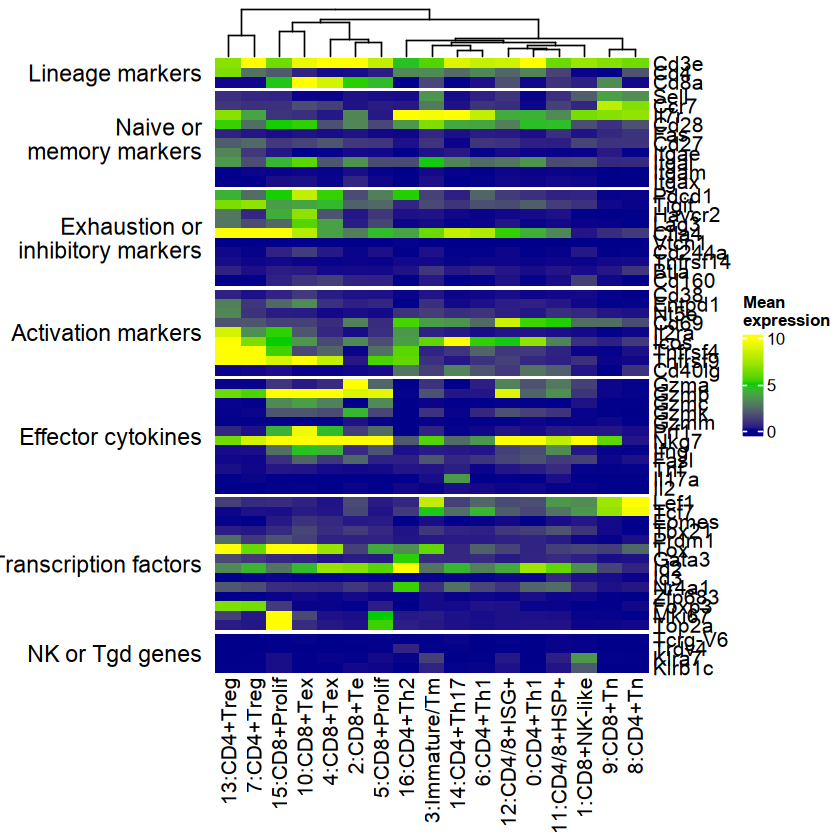

In [28]:
gene_groups <- c(rep('Lineage markers', 3),rep('Naive or\nmemory markers', 10),rep('Exhaustion or\ninhibitory markers',10),
                     rep('Activation markers',9),rep('Effector cytokines',12), rep('Transcription factors',14), rep('NK or Tgd genes',4))
gene_groups <- factor(gene_groups, levels=unique(gene_groups))
ht <- Heatmap(key_genes_mat, name='Mean\nexpression', cluster_rows=F, row_order=1:nrow(key_genes_mat),
        col = colorRamp2(c(0,5,10),c('darkblue','green3','yellow')),
        row_split=gene_groups,
        column_labels=levels(tc$cluster_annotation),
        column_title_side = c("bottom"), row_title_rot = 0)
ht
pdf('plot/b16_tc_key_genes_heatmap.pdf', height=11, width=6)
draw(ht)
dev.off()

In [29]:
tc_select_genes <- c('Il7r','Klrg1','Klf2','Gzmk','Gzma','Ccl5','Cxcr3','Gzmb','Prf1','Nkg7','Ifng',
                     'Pdcd1','Tigit','Lag3','Havcr2','Ctla4','Tox','Tnfrsf9',
                    'Mki67','Top2a','Ube2c','Cenpf')
cd8te <- subset(tc, annotation %in% c('CD8+Te','CD8+Tex','CD8+Prolif'), downsample = 1000)
Idents(cd8te) <- 'cluster_annotation'
cd8te <- ScaleData(cd8te, tc_select_genes) 

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


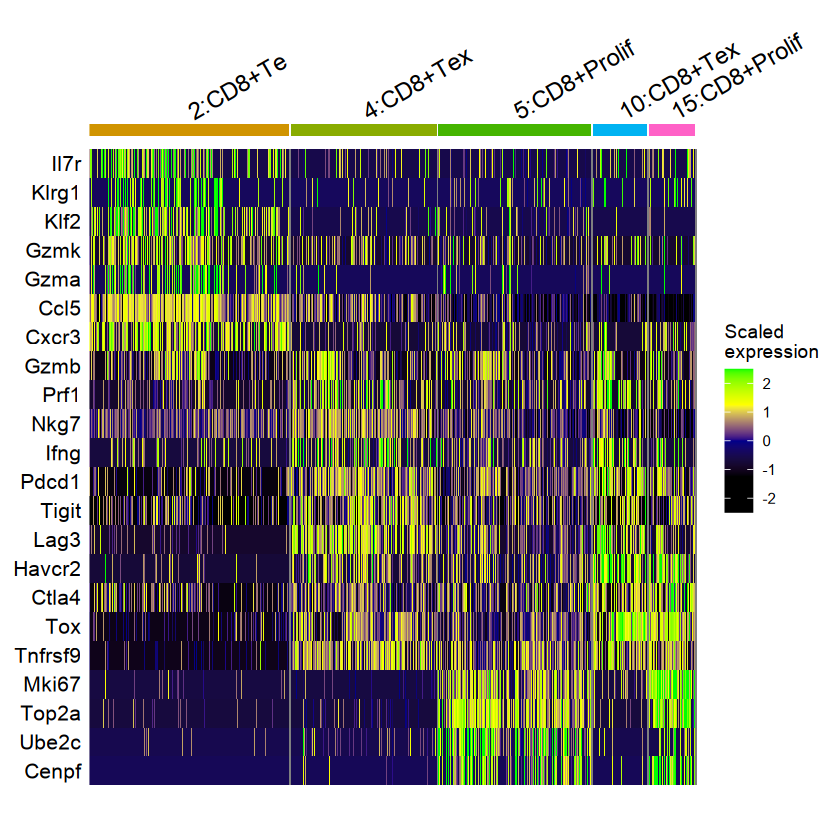

In [30]:
DoHeatmap(cd8te, tc_select_genes, size=5, angle=30, group.colors=hue_pal()(17)[c(2,4,5,10,15)+1]) + guides(color='none') + 
    labs(fill='Scaled\nexpression') +
    theme(axis.text.x=element_blank(), legend.title=element_text(color='black'), axis.text.y=element_text(color='black',size=12)) + 
    scale_fill_gradientn(colors=c('black','black','darkblue','yellow','green'))
ggsave('plot/b16_tc_eff_exh_gene_heatmap.pdf', height=4, width=7, device=pdf)

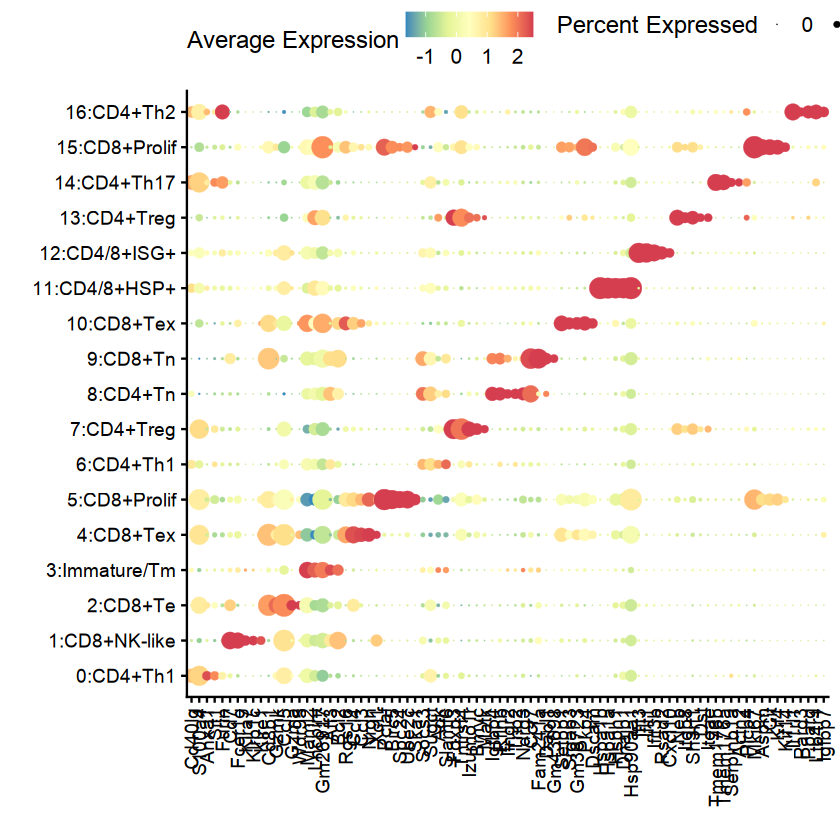

In [31]:
Idents(tc) <- 'cluster_annotation'
DotPlot(tc, features=markers_tc_cluster %>% filter(pct.1>0.3) %>% group_by(cluster) %>% top_n(5, wt=avg_log2FC) %>% pull(gene) %>% unique(), 
        dot.scale = 6, cols = 'Spectral') + 
    labs(y='',x='') + 
    theme(legend.position='top', axis.text=element_text(size=11), 
          plot.background = element_rect(fill = "white",colour = NA),
          axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 
ggsave('plot/b16_tcell_cluster_marker.pdf', width=12, height=6, device=pdf)

In [32]:
Idents(tc) <- 'annotation'
te_deg <- FindMarkers(tc, ident.1='CD8+Te')
te_ego <- enrichGO(te_deg %>% filter(avg_log2FC>1) %>% rownames(), OrgDb = org.Mm.eg.db, keyType = "SYMBOL", ont = "BP") 

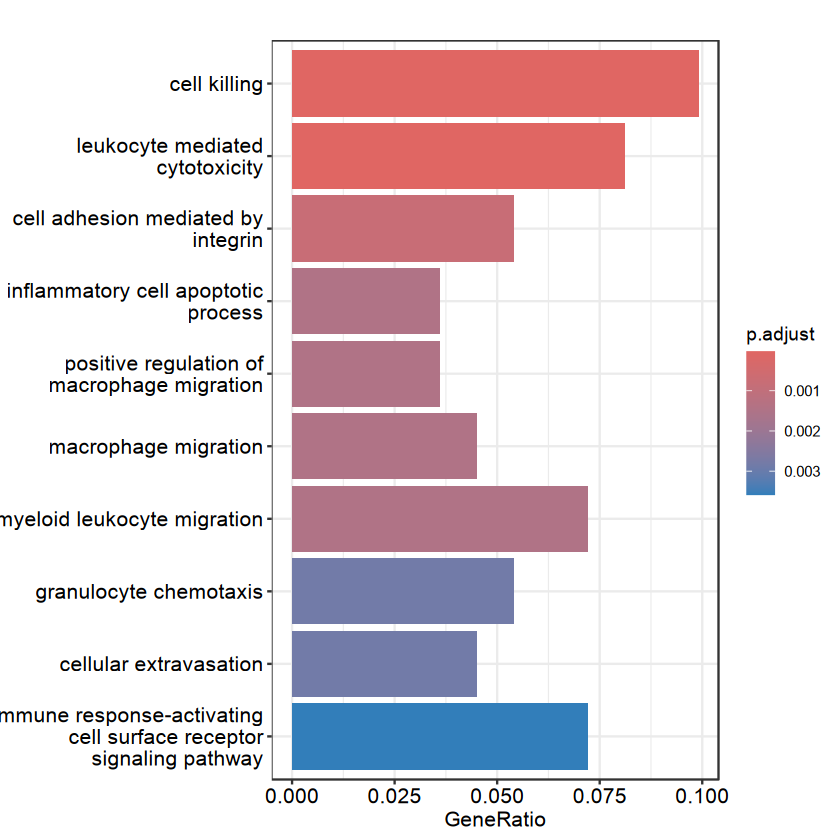

In [33]:
barplot(te_ego, x="GeneRatio", showCategory = 10)
ggsave('plot/b16_te_enrichment.pdf', width=6, height=5, device=pdf)

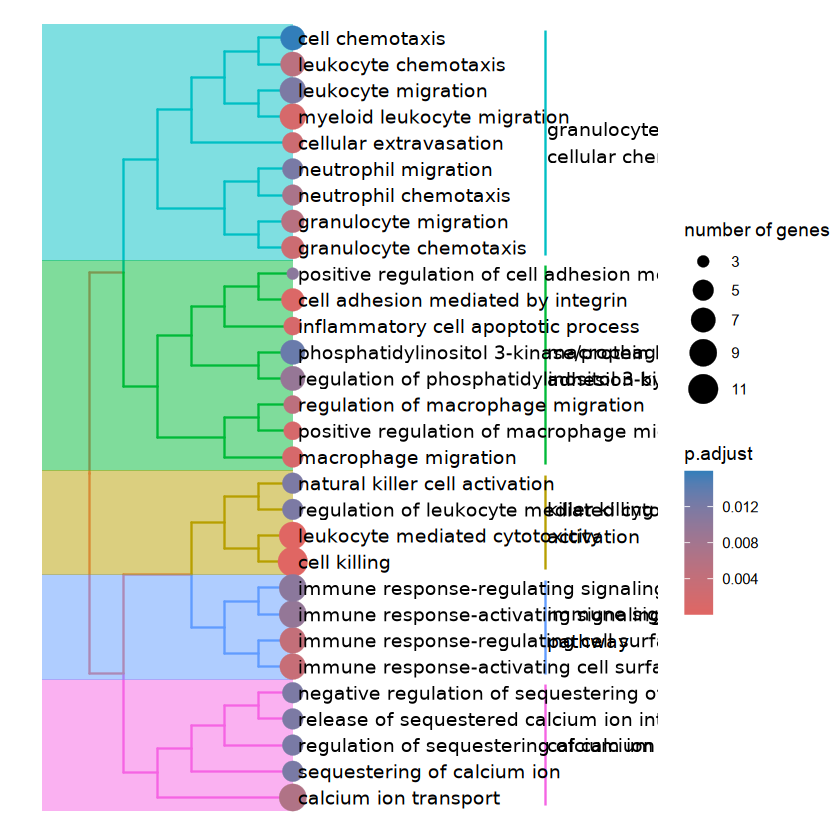

In [34]:
te_ego <- pairwise_termsim(te_ego)
treeplot(te_ego)

# proportion analysis

`summarise()` has grouped output by 'annotation', 'treatment', 'sample', 'VLP', 'aCTLA4'. You can override using the `.groups`
argument.
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


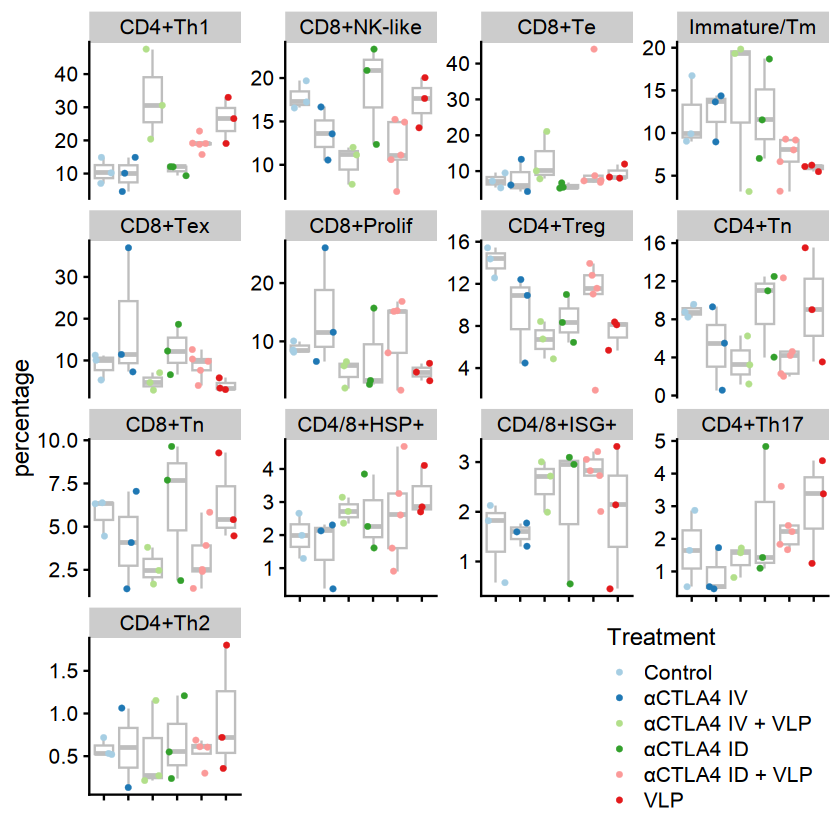

In [35]:
tc_anno_percent_df <- tc@meta.data %>% group_by(annotation, treatment, sample, VLP, aCTLA4, batch) %>% summarise(count=n()) %>% 
    ungroup() %>% group_by(sample) %>% mutate(count_sample = sum(count)) %>% mutate(percentage = count/count_sample*100)
ggplot(tc_anno_percent_df, aes(x=treatment, y=percentage, color=treatment)) + geom_boxplot(color='gray', alpha=0.5, outliers=F) + 
    facet_wrap(~annotation, scales='free_y') + 
    theme_cowplot() + labs(x='',fill='treatment') + geom_jitter() +
    scale_color_brewer(palette='Paired') + labs(color='Treatment') +
    theme(legend.position=c(0.7,0.1), axis.text.x=element_blank())
ggsave('plot/b16_t_cluster_prop.pdf', width=7, height=7, device=cairo_pdf)

Using sample, treatment as id variables



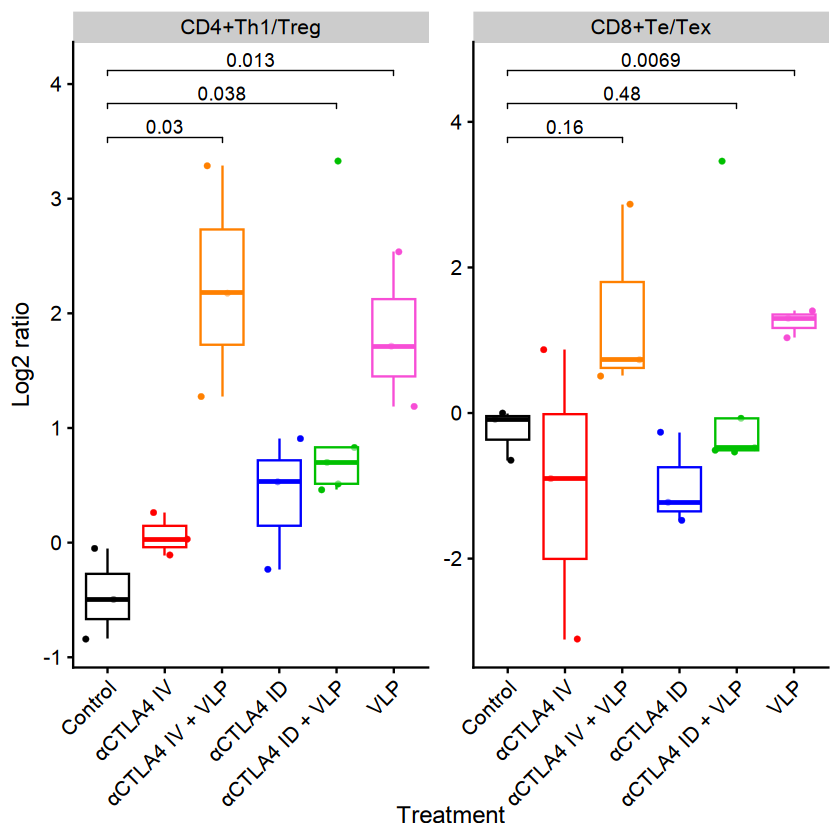

In [36]:
percent_fc <- tc_anno_percent_df %>% split(.$sample)  %>% 
    lapply(function(x) data.frame(CD4fc=log2(x$count[x$annotation=='CD4+Th1'] / x$count[x$annotation=='CD4+Treg']),
           CD8fc1=log2(x$count[x$annotation=='CD8+Te'] / x$count[x$annotation=='CD8+Tex']),
           treatment=unique(x$treatment)                      )) %>% bind_rows(.id = 'sample') 
percent_fc %>%melt() %>% ggplot(aes(y=value, x=treatment, color=treatment)) + 
               geom_jitter() + geom_boxplot(aes(color=treatment), alpha=0.5, outliers=F) + #color='gray', 
    facet_wrap(~variable, scales='free_y', ncol=2, 
               labeller=as_labeller(c('CD4fc'='CD4+Th1/Treg', 'CD8fc1'='CD8+Te/Tex', 'CD8fc2'='CD8+Prolif/Tex'))) + 
    theme_cowplot() + labs(x='Treatment', y='Log2 ratio', fill='treatment') + 
    scale_color_manual(values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) + labs(color='Treatment') +
    stat_compare_means(comparisons = list(c('Control', 'αCTLA4 IV + VLP'), c('Control', 'αCTLA4 ID + VLP'), c('Control', 'VLP')), 
                       step.increase=0.07, tip.length=0.01, method='t.test', vjust=0.2) +
    theme(legend.position='none', axis.text.x=element_text(angle=45, vjust=1, hjust=1))
ggsave('plot/b16_box_cluster_ratio.pdf', width=6, height=5, unit='in', device=cairo_pdf)

pdf 
  2

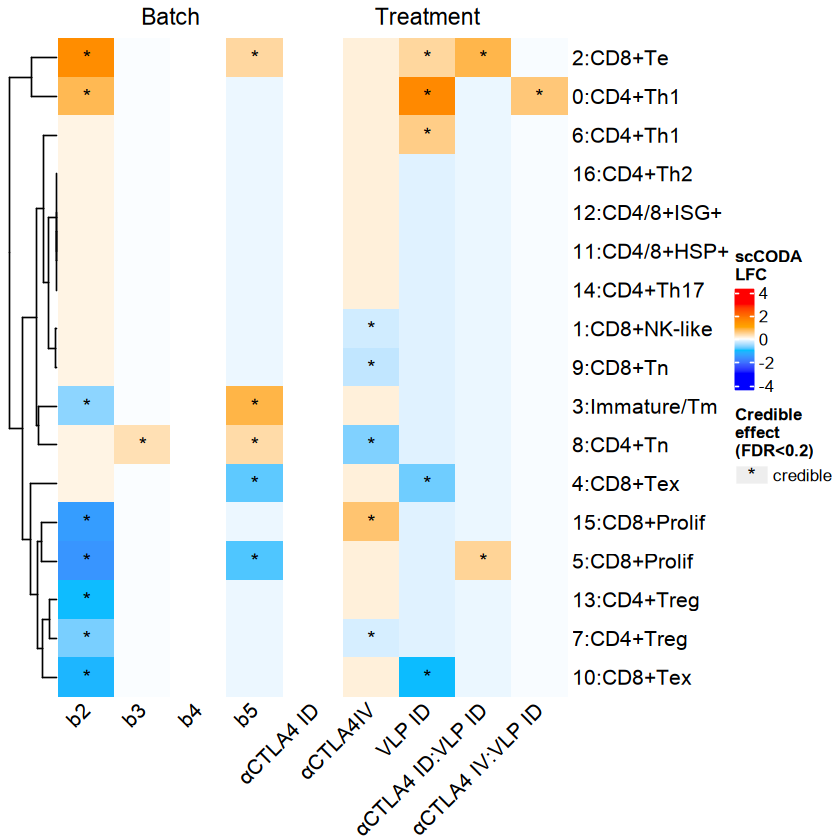

In [37]:
sccoda_df <- read.csv('csv/b16_tc_sccoda.csv')
lfc_mat <- sccoda_df %>% dcast(Cell.Type~ Covariate, value.var='log2.fold.change') %>% 
    column_to_rownames('Cell.Type') %>% as.matrix()
credible_mat <- sccoda_df %>% mutate(sig=ifelse(abs(Final.Parameter)>1e-10, '*', '')) %>% 
    dcast(Cell.Type~ Covariate, value.var='sig') %>% column_to_rownames('Cell.Type')
colnames(lfc_mat) <- c('b2','b3','b4','b5','αCTLA4 ID','αCTLA4IV','VLP ID','αCTLA4 ID:VLP ID','αCTLA4 IV:VLP ID')
lgd_sig <- Legend(title='Credible\neffect\n(FDR<0.2)', pch = c('*'), type = "points", grid_width = unit(7, "mm"),
                  labels = c('credible'))
ht <- Heatmap(lfc_mat, cluster_columns=F, name='scCODA\nLFC', col = colorRamp2(c(-3,-1,0,1,3),c('blue','deepskyblue','white','orange','red')),
              column_split = c(rep('Batch', 4),rep('Treatment', 5) ), row_labels = levels(tc$cluster_annotation),
              column_names_rot = 45,
              cell_fun = function(j, i, x, y, w, h, col) { grid.text(credible_mat[i,j], x, y) })
draw(ht, annotation_legend_list = lgd_sig, legend_grouping = "original", merge_legend = TRUE)
cairo_pdf('plot/b16_tc_cluster_scCODA.pdf', width=5, height=5.5)
draw(ht, annotation_legend_list = lgd_sig, legend_grouping = "original", merge_legend = TRUE)
dev.off()

# Differential expression

In [38]:
deg_list <- list()
Idents(tc) <- 'annotation'
annotation_i <- list('Tex'=c('CD8+Tex','CD8+Prolif'), 'Th1'='CD4+Th1', 'Te'='CD8+Te', 'Treg'='CD4+Treg','Prolif'='CD8+Prolif',
                     'ISG+T'='CD4/8+ISG+','HSP+T'='CD4/8+HSP+',
                     'Cd8T'=c('CD8+NK-like','CD8+Te','CD8+Prolif','CD8+Tex','CD8+Tn'),
                     'Cd4Th'=c('CD4+Th1','CD4+Tn','CD4+Th2','CD4+Th17'))
for(type_i in names(annotation_i))
{
    print(type_i)
    flush.console()
    suppressMessages({
        deg_list[[paste(type_i,'VLP ID vs none')]] <- FindMarkers(tc, subset.ident=annotation_i[[type_i]], test.use='MAST', latent.vars='batch', 
                           group.by='VLP', ident.1='ID', ident.2='none', logfc.threshold=0.01, min.pct=0.1) 
        deg_list[[paste(type_i,'aCTLA4 ID vs none')]] <- FindMarkers(tc, subset.ident=annotation_i[[type_i]], test.use='MAST', latent.vars='batch', 
                           group.by='aCTLA4', ident.1='ID', ident.2='none', logfc.threshold=0.01, min.pct=0.1) 
        deg_list[[paste(type_i,'aCTLA4 IV vs none')]] <- FindMarkers(tc, subset.ident=annotation_i[[type_i]], test.use='MAST', latent.vars='batch', 
                           group.by='aCTLA4', ident.1='IV', ident.2='none', logfc.threshold=0.01, min.pct=0.1) 
    })
}
saveRDS(deg_list, 'data/b16_tc_deg_list_mast_batch.rds')

[1] "Tex"
[1] "Th1"
[1] "Te"
[1] "Treg"
[1] "Prolif"
[1] "ISG+T"
[1] "HSP+T"
[1] "Cd8T"
[1] "Cd4Th"


In [39]:
deg_list <- readRDS('data/b16_tc_deg_list_mast_batch.rds')

In [40]:
for(type_i in c('Cd4Th','Cd8T','Th1','Tex','Te','Treg','ISG+T','HSP+T','Prolif'))#
{
    volcanos_type <- list()
    for(treat_i in c('VLP ID', 'aCTLA4 ID', 'aCTLA4 IV'))
    {
        deg_i <- deg_list[[paste(type_i,treat_i,'vs none')]] %>% rownames_to_column('gene') %>% 
            mutate(p.adj=ifelse(p_val_adj<0.05,'<0.05','>=0.05')) %>%
                         filter(!str_detect(gene, '^mt-|^Rpl|^Rps|^Hbb-|^Tr'))
        title_type <- type_i
        if(title_type == 'Cd4Th') title_type <- 'CD4+Th'
        else if(title_type == 'Cd8T') title_type <- 'CD8+T'
        volcano_i <- ggplot(deg_i, aes(x=avg_log2FC, y=-log10(p_val_adj))) + geom_point(aes(color=avg_log2FC)) +
            geom_hline(yintercept=-log10(0.05), linetype="dashed", color = "gray40") +
            geom_vline(xintercept=c(-0.5,0.5), linetype="dashed", color = "gray40") +
            geom_text_repel(data=deg_i %>% filter(p_val_adj<0.05 & abs(avg_log2FC)>0.5) , 
                    aes(label=gene), max.overlaps=10, ylim=c(0,180)) +
            theme_cowplot() + theme(legend.position='none') + 
            scale_color_gradient2(low='blue',mid='gray',high='red') + 
            labs(x=paste('LFC'), y='-log10(p.adj)', title=paste(title_type,'(factor:',str_replace(treat_i,'a','α'),'vs none)')) +
            theme(plot.title=element_text(face='plain'))
            
        ggsave(paste0('plot/b16_volcano_',type_i, '_',treat_i,'.pdf'), width=6, height=6, device=cairo_pdf)
        volcanos_type[[treat_i]] <- volcano_i
    }
    volcanos <- wrap_plots(volcanos_type, ncol=3)
    ggsave(paste0('plot/b16_volcano_',type_i,'.pdf'), width=15, height=5, device=cairo_pdf)
}


Warning message:
“ggrepel: 120 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 133 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 134 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 54 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 141 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 57 unl

Using treatment as id variables



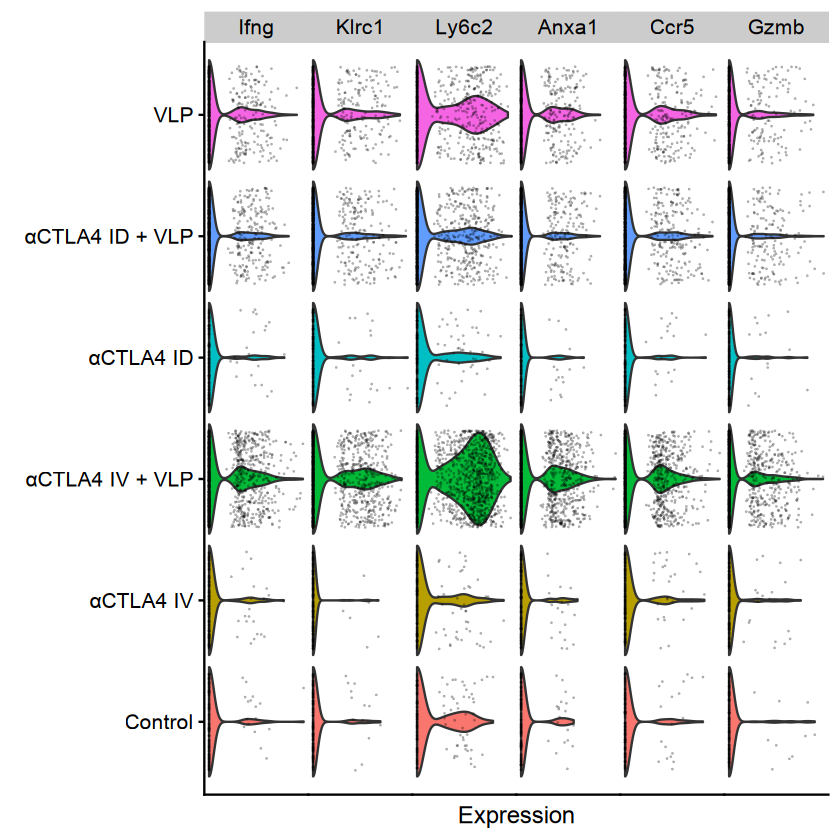

In [41]:
th1_top_degs <- FetchData(subset(tc, annotation == 'CD4+Th1'), c('Ifng','Klrc1','Ly6c2','Anxa1','Ccr5','Gzmb','treatment')) %>%
    melt(variable.name = 'gene', value.name='Expression')
ggplot(th1_top_degs, aes(y=treatment, x=Expression, fill=treatment)) + geom_violin(scale = 'width') + 
    geom_jitter(alpha=0.3, size=0.3) +
    facet_wrap(~gene, nrow=1, scales='free_x') + labs(y='') + theme_cowplot()  +
    theme(legend.position='none', panel.spacing = unit(0, "lines"), 
          axis.text.x=element_blank(), axis.ticks.x=element_blank()) #, strip.text.x = element_text(size = 9.5)

Using treatment as id variables



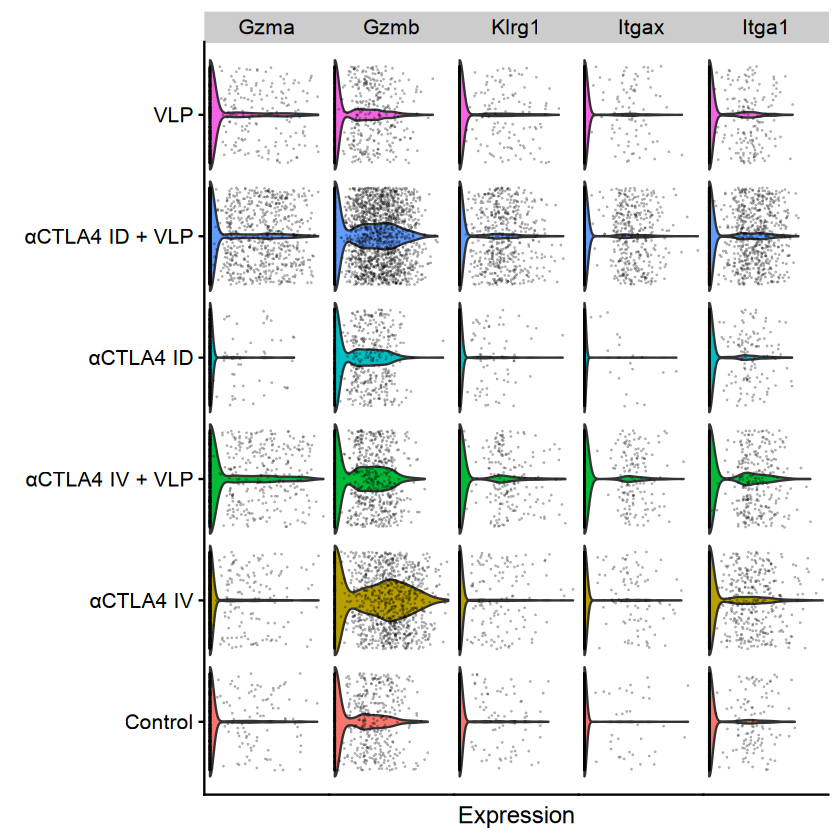

In [42]:
cd8t_top_degs <- FetchData(subset(tc, annotation %in% c('CD8+NK-like','CD8+Te','CD8+Prolif','CD8+Tex','CD8+Tn')), 
                           c('Gzma','Gzmb','Klrg1','Itgax','Itga1','treatment')) %>%
    melt(variable.name = 'gene', value.name='Expression')
ggplot(cd8t_top_degs, aes(y=treatment, x=Expression, fill=treatment)) + geom_violin(scale = 'width') + 
    geom_jitter(alpha=0.3, size=0.3) +
    facet_wrap(~gene, nrow=1, scales='free_x') + labs(y='') + theme_cowplot()  +
    theme(legend.position='none', panel.spacing = unit(0, "lines"), 
          axis.text.x=element_blank(), axis.ticks.x=element_blank()) #, strip.text.x = element_text(size = 9.5)

In [43]:
tc@meta.data <- tc@meta.data[,!str_detect(colnames(tc@meta.data),'RNA_snn')]
write.csv(tc@meta.data,'data/b16_tc_meta.csv', quote=T)
saveRDS(tc, 'data/b16_tc_5batch.rds')